In [1]:
# Imports
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix 
from timeit import default_timer as timer

In [29]:
# Let us first define all the important functions which we will be using throughout the notebook
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    total = len(y_pred)
    acc = (correct / total) * 100
    return acc

def evaluate_model(model, dataloader, lossFunction, accuracyFunction):
    loss = 0
    accuracy = 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,Y) in enumerate(dataloader):
            Y_pred = model(X)
            loss += lossFunction(Y_pred, Y)
            accuracy += accuracyFunction(Y, Y_pred.argmax(dim=1))
        loss /= len(dataloader)
        accuracy /= len(dataloader)
    return {"Model Name" : model.__class__.__name__, "Model Loss" : loss.item(), "Model Accuracy" : accuracy}

def train_loop(model, dataloader, lossFunction, optimizer, accuracyFunction):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch, (X, Y) in enumerate(dataloader):
        Y_pred = model(X)
        loss = lossFunction(Y_pred, Y)
        train_loss += loss
        train_acc += accuracyFunction(Y, Y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader) 
    train_acc /= len(train_dataloader)
    print(f"Train Loss -> {train_loss:.2f}\nTrain Accuracy -> {train_acc:.2f}%\n")
    
def test_loop(model, dataloader, lossFunction, accuracyFunction):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for batch, (X, Y) in enumerate(dataloader):
            Y_pred = model(X)
            loss = lossFunction(Y_pred, Y)
            test_loss += loss
            test_acc += accuracyFunction(Y, Y_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Test Loss -> {test_loss:.2f}\nTest Accuracy -> {test_acc:.2f}%\n")

def make_predictions(model, data):
    predictions = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            logits = model(sample.unsqueeze(dim=1))
            pred_probs = torch.softmax(logits, dim=1)
            pred_labels = torch.argmax(pred_probs, dim=1)
            predictions.append(pred_labels)
        return predictions

In [13]:
# Getting Data from FashionMNIST dataset
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)
classes = train_data.classes

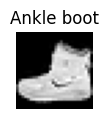

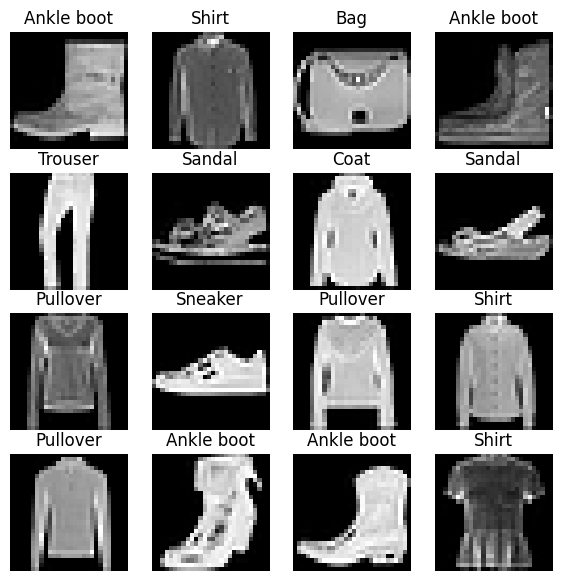

In [15]:
# Visualising Data
image0, label0 = train_data[0]
plt.figure(1, figsize=(1,1))
plt.imshow(image0.squeeze(), cmap='gray')
plt.title(classes[label0])
plt.axis(False)
plt.figure(2, figsize=(7,7))
rows = 4
columns = 4
torch.manual_seed(42)
for i in range(rows*columns):
    plt.subplot(rows,columns,i+1)
    random_index = torch.randint(0, len(train_data), [1]).item()
    image, label = train_data[random_index]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

In [16]:
# Dividing dataset into batches using DataLoader
BATCH_SIZE = 32
torch.manual_seed(42)
train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [17]:
# Model 1 (without any non linear layers)
class Model1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)
    
model1 = Model1(input_shape=784, hidden_units=10, output_shape=len(classes))
print(model1)

Model1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [19]:
# Training Model1
torch.manual_seed(42)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)
epochs = 3
start_time = timer()
for epoch in range(epochs):
    print(f"Epoch : {epoch}\n")
    train_loop(model1, train_dataloader, loss_function, optimizer, accuracy_function)
    test_loop(model1, test_dataloader, loss_function, accuracy_function)
end_time = timer()
total_time_model1 = end_time - start_time

Epoch : 0

Train Loss -> 0.59
Train Accuracy -> 79.17%

Test Loss -> 0.51
Test Accuracy -> 82.04%

Epoch : 1

Train Loss -> 0.48
Train Accuracy -> 83.32%

Test Loss -> 0.48
Test Accuracy -> 83.20%

Epoch : 2

Train Loss -> 0.46
Train Accuracy -> 84.05%

Test Loss -> 0.48
Test Accuracy -> 83.43%



In [20]:
# Evaluating Model1
model1_results = evaluate_model(model1, test_dataloader, loss_function, accuracy_function)
print(model1_results)

{'Model Name': 'Model1', 'Model Loss': 0.4766390025615692, 'Model Accuracy': 83.42651757188499}


In [21]:
# Model2 (introducing non linearity)
class Model2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)
    
model2 = Model2(input_shape=784, hidden_units=10, output_shape=len(classes))
print(model2)

Model2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [22]:
# Training Model2
torch.manual_seed(42)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)
epochs = 3
start_time = timer()
for epoch in range(epochs):
    print(f"Epoch : {epoch}\n")
    train_loop(model2, train_dataloader, loss_function, optimizer, accuracy_function)
    test_loop(model2, test_dataloader, loss_function, accuracy_function)
end_time = timer()
total_time_model2 = end_time - start_time

Epoch : 0

Train Loss -> 0.70
Train Accuracy -> 74.83%

Test Loss -> 0.52
Test Accuracy -> 81.38%

Epoch : 1

Train Loss -> 0.49
Train Accuracy -> 82.27%

Test Loss -> 0.50
Test Accuracy -> 82.00%

Epoch : 2

Train Loss -> 0.46
Train Accuracy -> 83.47%

Test Loss -> 0.48
Test Accuracy -> 82.52%



In [23]:
# Evaluating Model2
model2_results = evaluate_model(model2, test_dataloader, loss_function, accuracy_function)
print(model2_results)

{'Model Name': 'Model2', 'Model Loss': 0.4825581908226013, 'Model Accuracy': 82.5179712460064}


In [25]:
# Model3 (Convolutional Neural Network)
class CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=10*7*7, out_features=output_shape)
        )
    def forward(self, x):
        return self.classifier(self.block2(self.block1(x)))
    
model3 = CNN(input_shape=1, hidden_units=10, output_shape=len(classes))
print(model3)

CNN(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


In [26]:
# Training Model3
torch.manual_seed(42)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)
epochs = 3
start_time = timer()
for epoch in range(epochs):
    print(f"Epoch : {epoch}\n")
    train_loop(model3, train_dataloader, loss_function, optimizer, accuracy_function)
    test_loop(model3, test_dataloader, loss_function, accuracy_function)
end_time = timer()
total_time_model3 = end_time - start_time

Epoch : 0

Train Loss -> 0.66
Train Accuracy -> 75.70%

Test Loss -> 0.39
Test Accuracy -> 86.27%

Epoch : 1

Train Loss -> 0.35
Train Accuracy -> 87.34%

Test Loss -> 0.33
Test Accuracy -> 88.13%

Epoch : 2

Train Loss -> 0.31
Train Accuracy -> 88.76%

Test Loss -> 0.31
Test Accuracy -> 88.86%



In [27]:
# Evaluating Model3
model3_results = evaluate_model(model3, test_dataloader, loss_function, accuracy_function)
print(model3_results)

{'Model Name': 'CNN', 'Model Loss': 0.31117793917655945, 'Model Accuracy': 88.85782747603834}


In [28]:
# Now, let us compare all 3 of our models
comparison = pd.DataFrame([model1_results, model2_results, model3_results])
comparison["Training Time"] = [total_time_model1, total_time_model1, total_time_model3]
comparison

,Model Name,Model Loss,Model Accuracy,Training Time
0,Model1,0.476639,83.426518,28.941855
1,Model2,0.482558,82.517971,28.941855
2,CNN,0.311178,88.857827,135.772902


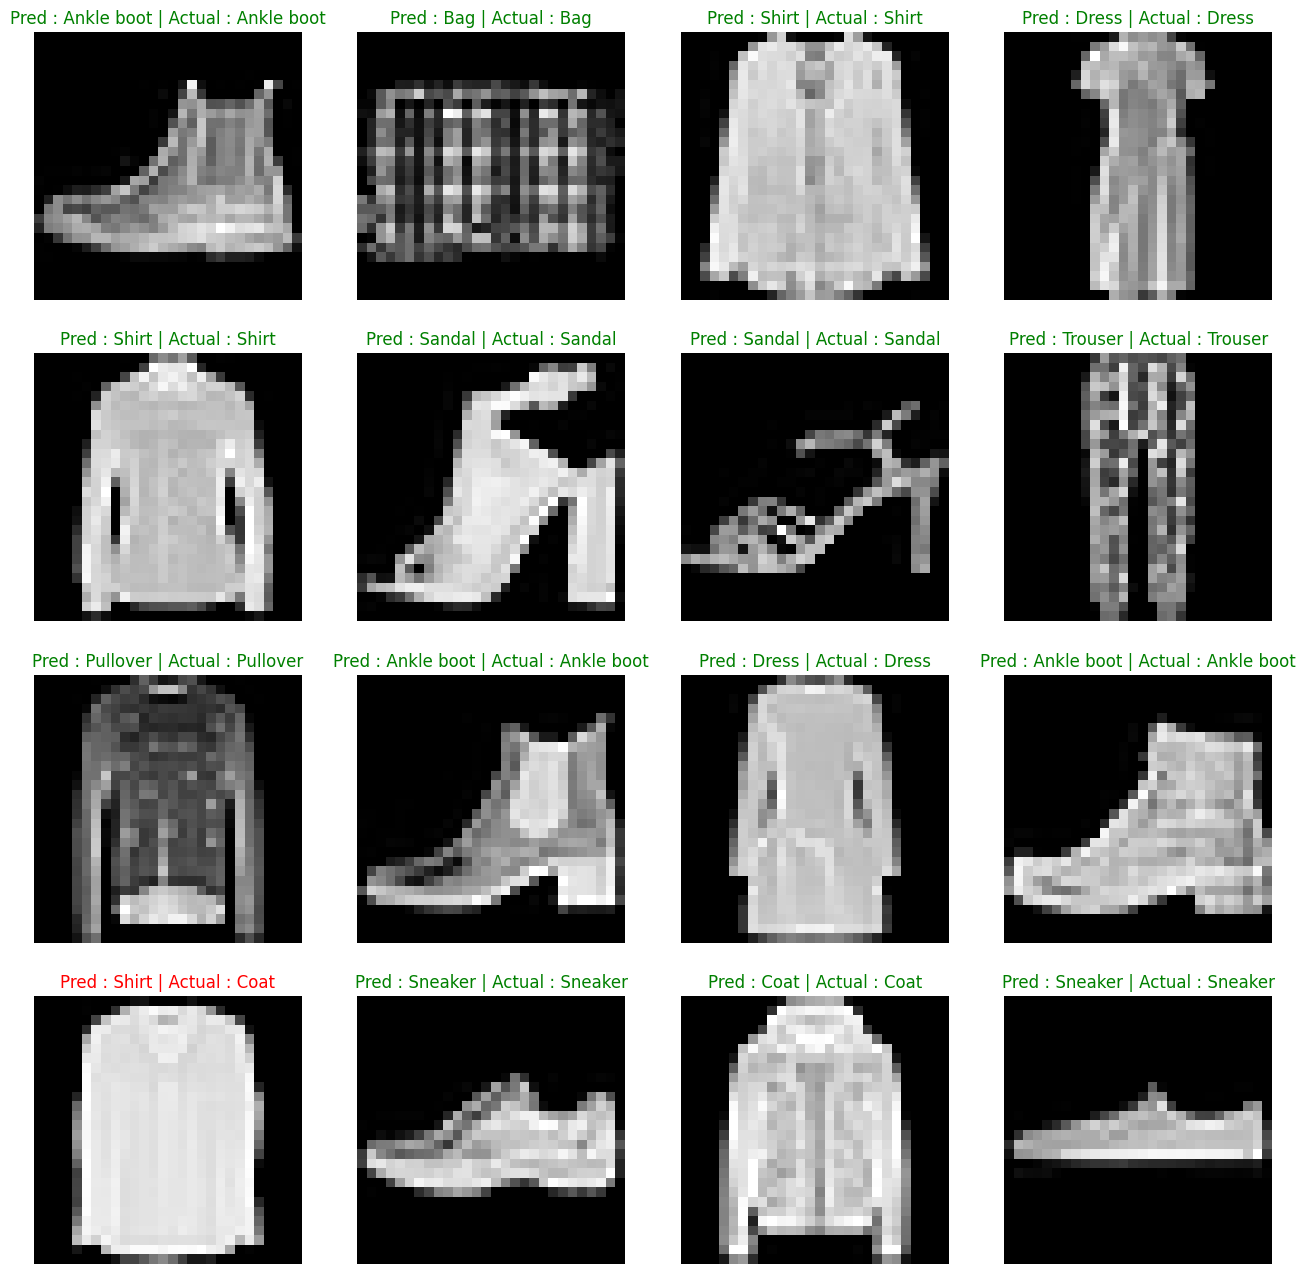

In [31]:
# Finally, we can use our CNN to make predictions on the test dataset
torch.manual_seed(42)
test_samples = []
test_labels = []
for i in range(16):
    random_index = torch.randint(0, len(test_data), [1]).item()
    test_samples.append(test_data[random_index][0])
    test_labels.append(test_data[random_index][1])
    
predictions = make_predictions(model3, test_samples)

plt.figure(1, figsize=(16,16))
rows = 4
columns = 4
for i in range(rows*columns):
    plt.subplot(rows,columns,i+1)
    image = test_samples[i]
    label = test_labels[i]
    actual_label = classes[test_labels[i]]
    predicted_label = classes[predictions[i].item()]
    title_text = f"Pred : {predicted_label} | Actual : {actual_label}"
    plt.imshow(image.squeeze(), cmap='gray')
    if (predicted_label == actual_label):
        plt.title(title_text, c="green")
    else:
        plt.title(title_text, c="red")
    plt.axis(False)

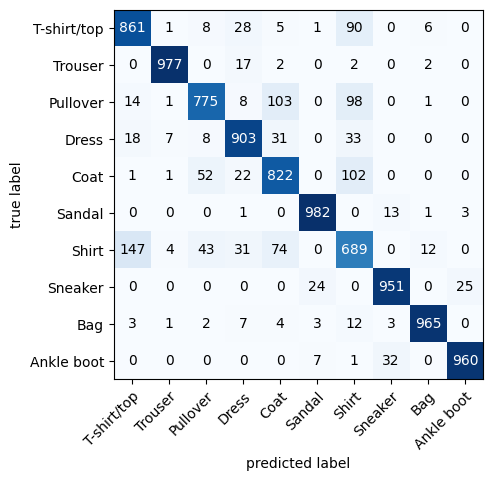

In [32]:
# We can also make a confusion matrix to use as an evaluation metric for our CNN Model
Y_preds = []
model3.eval()
with torch.inference_mode():
    for X,Y in test_dataloader:
        logits = model3(X)
        pred_probs = torch.softmax(logits, dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)
        Y_preds.append(pred_labels)
Y_preds_tensor = torch.cat(Y_preds)

confusion_matrix = ConfusionMatrix(num_classes=len(train_data.classes), task="multiclass")
confusion_matrix_tensor = confusion_matrix(preds=Y_preds_tensor, target=test_data.targets)

fig, ax  = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.numpy(), class_names=train_data.classes)

In [33]:
# Let us also save our model to our local machine so it can be loaded and used again in the future
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "pytorch_convolutional_neural_network.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
torch.save(obj=model2.state_dict(), f=MODEL_SAVE_PATH)